In [1]:
# Import libraries
import cv2
import numpy as np
import dlib
import requests
from PIL import Image

In [2]:
# Downloading shape_predictor
!wget 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

--2022-12-12 11:22:58--  https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat [following]
--2022-12-12 11:22:58--  https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat.1’

shape_predictor_68_ 100%[===================>]  95.08M   343MB/s    in 

In [3]:
# Extracting index from array
def extract_index_nparray(nparray):
  index = None
  for num in nparray[0]:
    index = num
    break
  return index

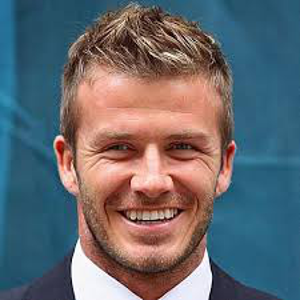

In [4]:
# Reading source image form url
image1 = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSx8Pu1tW1uCiZPfj9K1EL6uHxbg3bOKO9XkA&usqp=CAU', stream=True).raw)
image1 = image1.resize((300,300))
image1

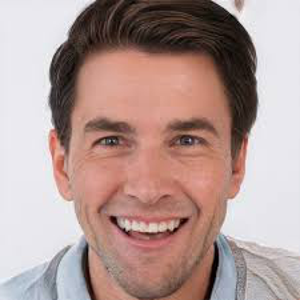

In [5]:
# Reading destination image form url
image2 = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTYX1dyl9INRo5cbvDeTILRcZVzfcMsCsE0kg&usqp=CAU', stream=True).raw)
image2 = image2.resize((300,300))
image2

In [6]:
# Converting image to array and converting them to grayscale
img = np.array(image1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [7]:
# Initializing frontal face detector and shape prediction
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)


In [8]:
# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)


ก่อนอื่นเราต้องส่งภาพไปยังเครื่องตรวจจับจากนั้นวัตถุนั้นจะใช้เพื่อแยกจุดสังเกตโดยใช้ตัวทำนาย จากนั้นจัดเก็บจุดสังเกตที่แยกออกมา x และ y ลงในรายการจุดสังเกต จากนั้นเราจะแบ่งใบหน้าออกเป็นสามเหลี่ยม ขั้นตอนนี้เป็นหัวใจหลักของการสลับใบหน้า หลังจากนั้นเราจะเปลี่ยนสามเหลี่ยมแต่ละอันกับสามเหลี่ยมที่สอดคล้องกันของภาพปลายทาง
รูปสามเหลี่ยมของรูปภาพปลายทางจะต้องมีรูปแบบรูปสามเหลี่ยมของรูปภาพต้นทางเหมือนกัน นั่นหมายความว่าการเชื่อมต่อของจุดจะต้องเหมือนกัน ดังนั้น หลังจากที่เราสร้างรูปสามเหลี่ยมของภาพต้นทางแล้ว จากรูปสามเหลี่ยมนั้น เราจะใช้ดัชนีของจุดสังเกต เพื่อให้เราสามารถจำลองรูปสามเหลี่ยมเดียวกันบนภาพปลายทางได้
เมื่อเรามีดัชนีรูปสามเหลี่ยมแล้ว เราก็ทำการวนซ้ำและกำหนดใบหน้าปลายทางให้เป็นสามเหลี่ยม

In [9]:
# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)


In [10]:
# Creating emtpy mask
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [11]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


ที่นี่เรากำลังดำเนินการเช่นเดียวกับด้านบนสำหรับภาพปลายทาง
หลังจากที่เราได้รูปสามเหลี่ยมของใบหน้าทั้งสองแล้ว เราก็นำรูปสามเหลี่ยมของใบหน้าต้นทางมาแยกออก
เราต้องใช้พิกัดของสามเหลี่ยมของใบหน้าปลายทางด้วย เพื่อที่เราจะสามารถบิดสามเหลี่ยมของใบหน้าต้นทางให้มีขนาดและมุมมองของสามเหลี่ยมที่ตรงกันบนใบหน้าปลายทางได้

In [12]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


เมื่อเราตัดและห่อสามเหลี่ยมทั้งหมดแล้ว เราต้องเชื่อมโยงเข้าด้วยกัน
เราเพียงแค่สร้างใบหน้าขึ้นมาใหม่โดยใช้รูปแบบสามเหลี่ยม โดยมีข้อแตกต่างเพียงอย่างเดียวคือคราวนี้เราใส่สามเหลี่ยมที่ห่อไว้

In [13]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

ใบหน้าพร้อมที่จะเปลี่ยนแล้ว เราตัดใบหน้าของภาพปลายทางออกเพื่อให้มีที่ว่างสำหรับใบหน้าใหม่

เราจึงนำใบหน้าใหม่และภาพปลายทางที่ไม่มีใบหน้ามาเชื่อมเข้าด้วยกัน

In [14]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

ในที่สุดก็สลับใบหน้ากันอย่างถูกต้องแล้วก็ถึงเวลาปรับสีเพื่อให้รูปภาพต้นทางพอดีกับรูปภาพปลายทาง

ใน Opencv เรามีฟังก์ชันในตัวที่เรียกว่า “seamlessClone” ซึ่งดำเนินการนี้โดยอัตโนมัติ
เราต้องเอาใบหน้าใหม่ (สร้างในขั้นตอนที่ 6) นำภาพปลายทางเดิมและมาสก์เพื่อตัดใบหน้าออก เราต้องได้ศูนย์กลางของใบหน้า

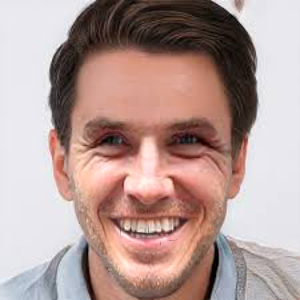

In [15]:
# Converting array to image
Image.fromarray(seamlessclone)

# Conclusion
เราเริ่มต้นด้วยการดาวน์โหลดโมเดลสำเร็จรูปสำหรับจุดสังเกตใบหน้าและดาวน์โหลดรูปภาพจากอินเทอร์เน็ตที่เราจะใช้งาน ต่อไปเราใช้ CV2 และ Dlib เพื่อประมวลผลภาพล่วงหน้าและใช้ฟังก์ชันการทำงานที่แตกต่างกันเพื่อไปให้ถึงจุดสิ้นสุด ซึ่งเป็นการสลับหน้าของภาพปลายทางกับภาพต้นฉบับ

# Scope
โครงการนี้สามารถใช้เพื่อการเรียนรู้และทำความเข้าใจแนวคิดต่างๆ ของคอมพิวเตอร์วิทัศน์ โครงการนี้สามารถใช้สร้างแอปพลิเคชัน Augmented Reality เช่น Snapchat เป็นต้น